In [116]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings(action='ignore')
import pickle
import time
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier # model 
from xgboost import plot_importance
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint
import sklearn.svm as svm
from matplotlib_venn import venn2, venn2_circles


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [104]:
import sys   
!{sys.executable} -m pip install time

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [105]:
def seed_everything(seed):
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed) #넘파이를 사용할 경우

seed_everything(37) # Seed 고정

# Data Load

In [106]:
#데이터프레임 불러오기
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [107]:
sub1 = pd.read_csv('./sample_submission.csv')
sub2 = pd.read_csv('./sample_submission.csv')
sub3= pd.read_csv('./sample_submission.csv')
sub4= pd.read_csv('./sample_submission.csv')

In [108]:
sub5 = pd.read_csv('./sample_submission.csv')
sub6 = pd.read_csv('./sample_submission.csv')
sub7= pd.read_csv('./sample_submission.csv')
sub8= pd.read_csv('./sample_submission.csv')

In [109]:
sub9 = pd.read_csv('./sample_submission.csv')
sub10 = pd.read_csv('./sample_submission.csv')
sub11= pd.read_csv('./sample_submission.csv')
sub12= pd.read_csv('./sample_submission.csv')

# Data Preprocessing

PRODUCT_CODE 데이터 나누기

1.train_df

In [68]:
train_010 = train_df[(train_df['LINE']=='T010306') | (train_df['LINE']=='T010305')]
train_050 = train_df[(train_df['LINE']=='T050304') | (train_df['LINE']=='T050307')]
train_100 = train_df[(train_df['LINE']=='T100304') | (train_df['LINE']=='T100306')]

In [69]:
test_010 = test_df[(test_df['LINE']=='T010306') | (test_df['LINE']=='T010305')]
test_050 = test_df[(test_df['LINE']=='T050304') | (test_df['LINE']=='T050307')]
test_100 = test_df[(test_df['LINE']=='T100304') | (test_df['LINE']=='T100306')]

In [70]:
print(len(train_010))
print(len(train_050))
print(len(train_100))
print(len(test_010))
print(len(test_050))
print(len(test_100))

129
120
349
28
39
243


In [71]:
rem_col_010 = train_010.isnull().sum()[train_010.isnull().sum() == 129].index.tolist() #나중에 지워야함
rem_col_050 = train_050.isnull().sum()[train_050.isnull().sum() == 120].index.tolist()
rem_col_100 = train_100.isnull().sum()[train_100.isnull().sum() == 349].index.tolist()

In [72]:
rem_col_010_ts = test_010.isnull().sum()[test_010.isnull().sum() == 28].index.tolist()
rem_col_050_ts = test_050.isnull().sum()[test_050.isnull().sum() == 39].index.tolist()
rem_col_100_ts = test_100.isnull().sum()[test_100.isnull().sum() == 243].index.tolist()

모든 행이 결측치인 column이 traindf와 testdf가 다르다. 고로 삭제하면 안 될 것 같다.

010라인 : train = 1981 test 1991

050라인 : train = 888 test 1306

100라인 : train = 1318 test 2204

010, 050, 100 라인별로 train에서 null로 채워진 column을 지우고 test에도 제거해도될지 알아봤다
-> x

In [73]:
s1 = set(rem_col_010)
s2 = set(rem_col_010_ts)

In [74]:
def draw_venn(sets):
    venn2(subsets=sets, set_labels=('Set1', 'Set2'))
    plt.show()

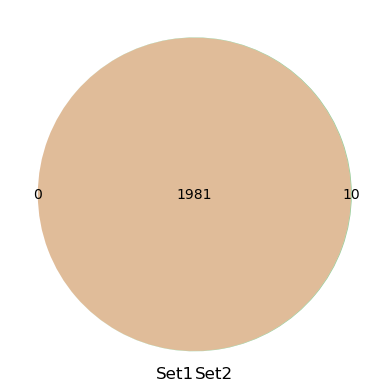

In [75]:
draw_venn([s1, s2]) #010 라인의 test가 null column이 더 많다. 어쨌든 교집합 추려서 삭제

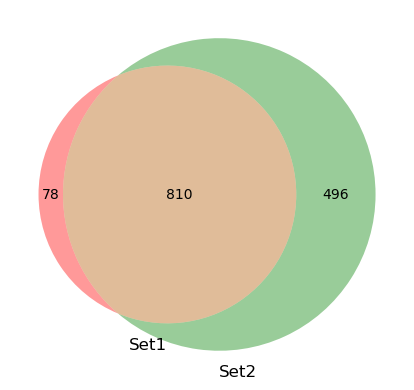

In [76]:
s3 = set(rem_col_050) #050 라인
s4 = set(rem_col_050_ts)
draw_venn([s3, s4])

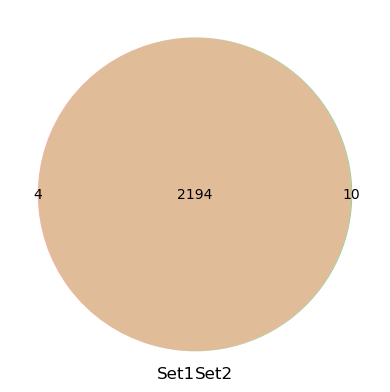

In [77]:
s5 = set(rem_col_100)
s6 = set(rem_col_100_ts)
draw_venn([s5, s6])

아무래도 시간이 지나면서 testdf에서 어떠한 측정값이 추가되고, 어떠한 측정값은 사라지는 것으로 보인다. 따라서 traindf와 testdf 둘 다에서 쓸모 없는 column을 제거한다. 

라인별 교집합 추리기(null column 삭제하기 위해)

In [78]:
inter_010 = s1.intersection(s2)

In [79]:
inters_010 = list(inter_010)

In [80]:
inter_050 = s3.intersection(s4)

In [81]:
inters_050 = list(inter_050)

In [82]:
inter_100 = s5.intersection(s6)

In [83]:
inters_100 = list(inter_100)

In [84]:
train_drop_010 = train_010.drop(inters_010, axis=1)

In [85]:
train_drop_050 = train_050.drop(inters_050, axis=1)

In [86]:
train_drop_100 = train_100.drop(inters_100, axis=1)

In [87]:
test_drop_010 = test_010.drop(inters_010, axis=1)

In [88]:
test_drop_050 = test_050.drop(inters_050, axis=1)

In [89]:
test_drop_100 = test_100.drop(inters_100, axis=1)

In [90]:
train_drop_df = pd.concat([train_drop_010, train_drop_050, train_drop_100], axis = 0)

In [91]:
test_drop_df = pd.concat([test_drop_010, test_drop_050, test_drop_100], axis = 0)

In [93]:
train_drop_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_246,X_247,X_248,X_249,...,X_928,X_929,X_930,X_931,X_932,X_933,X_934,X_935,X_936,X_937
27,TRAIN_027,2,0.540002,2022-06-19 20:18,T010306,A_31,1.0,87.0,144.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,TRAIN_028,0,0.521249,2022-06-19 20:26,T010305,A_31,1.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,TRAIN_031,2,0.536206,2022-06-20 21:55,T010306,A_31,4.0,93.0,150.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,TRAIN_032,2,0.548592,2022-06-21 7:06,T010306,A_31,1.0,89.0,152.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,TRAIN_033,1,0.526656,2022-06-21 7:14,T010305,A_31,1.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,TRAIN_591,1,0.529308,2022-09-07 1:09,T100306,T_31,NaN,NaN,NaN,NaN,...,326.0,313.472727,298.0,13.6,13.400000,13.2,NaN,NaN,NaN,NaN
592,TRAIN_592,1,0.528349,2022-09-08 14:22,T100304,T_31,NaN,NaN,NaN,NaN,...,326.0,312.472727,298.0,13.6,13.361290,13.2,NaN,NaN,NaN,NaN
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,NaN,NaN,NaN,NaN,...,327.0,313.363636,298.0,13.6,13.351613,13.2,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,NaN,NaN,NaN,NaN,...,321.0,303.036364,289.0,13.6,13.406667,13.2,NaN,NaN,NaN,NaN


In [97]:
train_010 = train_drop_df[(train_drop_df['LINE']=='T010306') | (train_drop_df['LINE']=='T010305')]
train_050 = train_drop_df[(train_drop_df['LINE']=='T050304') | (train_drop_df['LINE']=='T050307')]
train_100 = train_drop_df[(train_drop_df['LINE']=='T100304') | (train_drop_df['LINE']=='T100306')]

In [98]:
test_010 = test_drop_df[(test_drop_df['LINE']=='T010306') | (test_drop_df['LINE']=='T010305')]
test_050 = test_drop_df[(test_drop_df['LINE']=='T050304') | (test_drop_df['LINE']=='T050307')]
test_100 = test_drop_df[(test_drop_df['LINE']=='T100304') | (test_drop_df['LINE']=='T100306')]

### Feature Selection

outlier 이상체 제거한 최종 데이터 프레임 저장하기 & 모든 value가 결측치이거나 0.0인 행 지운 test data도 저장하기

In [94]:
train_drop_df.to_csv('./train_remnullcol_t31.csv', index = False) 

In [95]:
test_drop_df.to_csv('./test_remnullcol_t31.csv', index = False) 

모델링을 하기 앞서, 독립변수 X와 종속변수 y를 설정해야한다.

**학습에 사용할 변수 X와 예측할 변수 y를 분리**

In [110]:
train_y = train_df['Y_Class']

In [ ]:
train_y = train_050['Y_Class']

In [ ]:
train_y = train_100['Y_Class']

학습에 쓰이지 않을 column들을 제거한다.

In [111]:
train_x = train_df.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [ ]:
train_x = train_050.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
test_x = test_050.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

In [ ]:
train_x = train_100.drop(columns = ['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
test_x = test_100.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

범주형 데이터를 수치 데이터로 전환하기 위해 LabelEncoder 활용

In [112]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i]) #원래 column 값을 기준으로 fit.
    train_x[i] = le.transform(train_x[i]) #수치화, 수치로 변형

    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


In [112]:
test_x.isnull().sum()[test_x.isnull().sum() > 0]

X_2628    12
X_2629    12
X_2630    12
X_2631    12
X_2632    12
          ..
X_2696    12
X_2697    12
X_2698    12
X_2699    12
X_2844    12
Length: 73, dtype: int64

### Modeling

1.모델 선택 - sklearn라이브러리 활용 - RandomForest 

2.모델 학습 - train_df를 활용하여 1번에서 정의한 모델로 학습

3.예측 - 학습된 모델을 바탕으로 test 데이터를 예측

4.정답 파일 생성 - 정답 파일 생성 및 제출 필요(경진대회를 위해 필요한 과정.)

subRF_r = pd.read_csv('./sample_submission.csv')
subXGB_r = pd.read_csv('./sample_submission.csv')
sub_v = pd.read_csv('./sample_submission.csv')

학습용과 테스트용 데이터 세트를 위해 별도의 Dmatrix를 생성

In [113]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    test_size=0.1, 
                                                    stratify=train_y, 
                                                    random_state=37)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params = {'max_depth' : 6,
          'eta': 0.035,
          'objective':'multi:softmax',
          'num_class':3,
          'eval_metric':'mlogloss'
          }
num_rounds = 400

wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params, 
                      dtrain=dtrain, 
                      num_boost_round=num_rounds, 
                      early_stopping_rounds=100, 
                      evals=wlist)

[0]	train-mlogloss:1.06414	eval-mlogloss:1.07218
[1]	train-mlogloss:1.03142	eval-mlogloss:1.04668
[2]	train-mlogloss:1.00052	eval-mlogloss:1.02519
[3]	train-mlogloss:0.97054	eval-mlogloss:1.00240
[4]	train-mlogloss:0.94299	eval-mlogloss:0.98364
[5]	train-mlogloss:0.91671	eval-mlogloss:0.96251
[6]	train-mlogloss:0.89149	eval-mlogloss:0.94173
[7]	train-mlogloss:0.86732	eval-mlogloss:0.92338
[8]	train-mlogloss:0.84442	eval-mlogloss:0.90463
[9]	train-mlogloss:0.82251	eval-mlogloss:0.88676
[10]	train-mlogloss:0.80135	eval-mlogloss:0.86907
[11]	train-mlogloss:0.78150	eval-mlogloss:0.85287
[12]	train-mlogloss:0.76243	eval-mlogloss:0.83708
[13]	train-mlogloss:0.74417	eval-mlogloss:0.82313
[14]	train-mlogloss:0.72705	eval-mlogloss:0.80971
[15]	train-mlogloss:0.71031	eval-mlogloss:0.79851
[16]	train-mlogloss:0.69456	eval-mlogloss:0.78730
[17]	train-mlogloss:0.67880	eval-mlogloss:0.77663
[18]	train-mlogloss:0.66375	eval-mlogloss:0.76521
[19]	train-mlogloss:0.64977	eval-mlogloss:0.75537
[20]	train

[163]	train-mlogloss:0.08658	eval-mlogloss:0.54319
[164]	train-mlogloss:0.08580	eval-mlogloss:0.54360
[165]	train-mlogloss:0.08513	eval-mlogloss:0.54335
[166]	train-mlogloss:0.08432	eval-mlogloss:0.54375
[167]	train-mlogloss:0.08355	eval-mlogloss:0.54421
[168]	train-mlogloss:0.08263	eval-mlogloss:0.54343
[169]	train-mlogloss:0.08186	eval-mlogloss:0.54386
[170]	train-mlogloss:0.08103	eval-mlogloss:0.54450
[171]	train-mlogloss:0.08021	eval-mlogloss:0.54430
[172]	train-mlogloss:0.07954	eval-mlogloss:0.54411
[173]	train-mlogloss:0.07879	eval-mlogloss:0.54337
[174]	train-mlogloss:0.07806	eval-mlogloss:0.54366
[175]	train-mlogloss:0.07740	eval-mlogloss:0.54397
[176]	train-mlogloss:0.07670	eval-mlogloss:0.54462
[177]	train-mlogloss:0.07605	eval-mlogloss:0.54556
[178]	train-mlogloss:0.07541	eval-mlogloss:0.54595
[179]	train-mlogloss:0.07477	eval-mlogloss:0.54635
[180]	train-mlogloss:0.07410	eval-mlogloss:0.54706
[181]	train-mlogloss:0.07353	eval-mlogloss:0.54824
[182]	train-mlogloss:0.07288	ev

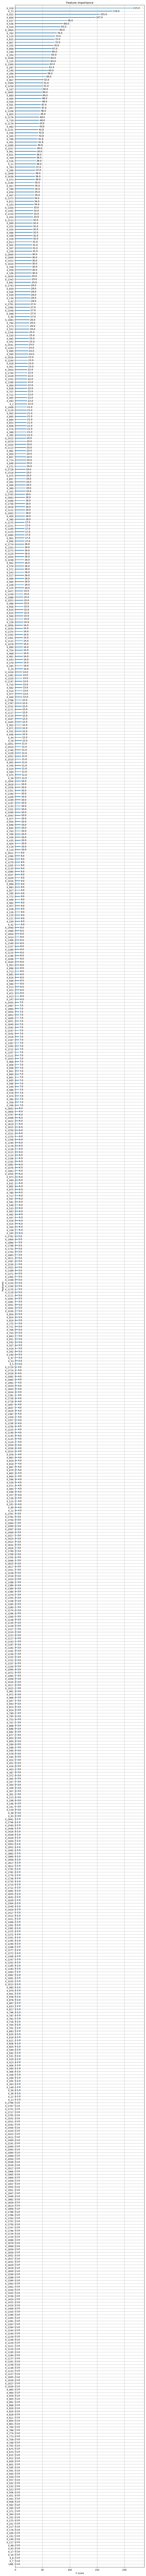

In [115]:
fig, ax = plt.subplots(figsize=(10, 200))
plot_importance(xgb_model, ax=ax)
plt.savefig('./feature_importance')

In [95]:
print(xgb_model.best_iteration)
print(xgb_model.best_ntree_limit)
print(xgb_model.best_score)

134
135
0.5403464787950119


In [96]:
y_pred = xgb_model.predict(dtest, ntree_limit=xgb_model.best_ntree_limit)
preds = np.round(y_pred).astype(int)
print(f1_score(y_test, preds, average = 'macro'))

0.8070874861572537


In [10]:
pred_probs = xgb_model.predict(dtest_x, ntree_limit=xgb_model.best_ntree_limit)
preds = np.round(pred_probs).astype(int)
sub3['Y_Class'] = preds
sub3.to_csv('./t31_XGB_Dmatrix_Earlystopping_eta0035_testsize01.csv', index = False)

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨


array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [100]:
results = xgb_model.eval(dtest)
results

'[0]\teval-mlogloss:0.54702019810987013'

In [135]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    test_size=0.2, 
                                                    stratify=train_y, 
                                                    random_state=37)

model = xgb.XGBClassifier(n_estimators=200, 
                          max_depth=6, 
                          learning_rate=0.08, 
                          base_score = 1, 
                          reg_lambda = 5,
                         reg_alpha = 2,
                         colsample_bytree = 0.5)
model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=20) 

[0]	validation_0-mlogloss:1.03398	validation_1-mlogloss:1.04613
[1]	validation_0-mlogloss:0.97648	validation_1-mlogloss:1.00124
[2]	validation_0-mlogloss:0.92557	validation_1-mlogloss:0.96092
[3]	validation_0-mlogloss:0.87821	validation_1-mlogloss:0.92396
[4]	validation_0-mlogloss:0.83694	validation_1-mlogloss:0.89395
[5]	validation_0-mlogloss:0.80024	validation_1-mlogloss:0.86601
[6]	validation_0-mlogloss:0.76574	validation_1-mlogloss:0.84095
[7]	validation_0-mlogloss:0.73522	validation_1-mlogloss:0.81960
[8]	validation_0-mlogloss:0.70618	validation_1-mlogloss:0.80052
[9]	validation_0-mlogloss:0.67848	validation_1-mlogloss:0.78348
[10]	validation_0-mlogloss:0.65421	validation_1-mlogloss:0.76868
[11]	validation_0-mlogloss:0.63155	validation_1-mlogloss:0.75674
[12]	validation_0-mlogloss:0.61065	validation_1-mlogloss:0.74300
[13]	validation_0-mlogloss:0.58991	validation_1-mlogloss:0.73169
[14]	validation_0-mlogloss:0.57227	validation_1-mlogloss:0.72069
[15]	validation_0-mlogloss:0.55432	

XGBClassifier(base_score=1, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.08, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=2, ...)

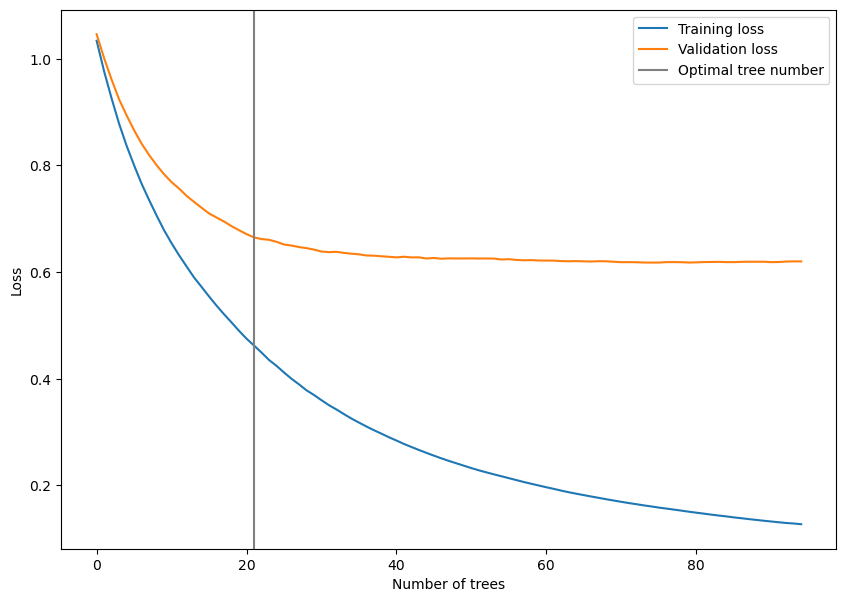

In [136]:
results = model.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [137]:
model.best_ntree_limit

75

In [138]:
preds2 = model.predict(test_x, ntree_limit=model.best_ntree_limit)
pred2 = np.round(preds, 0).astype(int)
pred2

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 0, 1,
       0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [127]:
pred

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 0, 1,
       0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [139]:
if (pred2 == pred).all():
    print('yes')

yes


In [40]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    test_size=0.3, 
                                                    stratify=train_y, 
                                                    random_state=37)

In [41]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [46]:
print('Accuracy:', round(accuracy_score(y_test, y_preds) * 100,2),'%')
print('f1-score:', round(f1_score(y_test, y_preds, average = 'macro') * 100,2),'%')

Accuracy: 76.11 %
f1-score: 59.49 %


In [49]:
model = XGBClassifier()

model.fit(X_train, 
          y_train, 
          eval_metric="merror", 
          eval_set=[(X_test, y_test)], 
          verbose=True)

[0]	validation_0-merror:0.26667
[1]	validation_0-merror:0.24444
[2]	validation_0-merror:0.26111
[3]	validation_0-merror:0.25000
[4]	validation_0-merror:0.24444
[5]	validation_0-merror:0.25556
[6]	validation_0-merror:0.24444
[7]	validation_0-merror:0.23889
[8]	validation_0-merror:0.23333
[9]	validation_0-merror:0.22778
[10]	validation_0-merror:0.22778
[11]	validation_0-merror:0.22778
[12]	validation_0-merror:0.22778
[13]	validation_0-merror:0.22778
[14]	validation_0-merror:0.22778
[15]	validation_0-merror:0.22778
[16]	validation_0-merror:0.22778
[17]	validation_0-merror:0.22222
[18]	validation_0-merror:0.22222
[19]	validation_0-merror:0.23333
[20]	validation_0-merror:0.22778
[21]	validation_0-merror:0.22222
[22]	validation_0-merror:0.22778
[23]	validation_0-merror:0.22778
[24]	validation_0-merror:0.22222
[25]	validation_0-merror:0.23333
[26]	validation_0-merror:0.22222
[27]	validation_0-merror:0.22222
[28]	validation_0-merror:0.21667
[29]	validation_0-merror:0.21111
[30]	validation_0-me

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [50]:
print('Accuracy:', round(accuracy_score(y_test, y_preds) * 100,2),'%')
print('f1-score:', round(f1_score(y_test, y_preds, average = 'macro') * 100,2),'%')

Accuracy: 76.11 %
f1-score: 59.49 %


# Randomsearch

1.XGB randomsearch

### XGB randomsearch

사이킷런 래퍼(randomsearch에 들어가 있는 것.)

learning rate, n_estimators, min_child_weight, min_split_loss, max_depth, reg_lambda, reg_alpha

In [149]:
param_distribs = {
#     'eta' : randint(low = 0.01, high = 0.1),
    'n_estimators': randint(low = 30, high = 200),
    'min_child_weight': randint(low = 1, high = 10),
    'min_split_loss': randint(low = 1, high = 10),
    'max_depth': randint(low = 1, high = 8),
     'reg_lambda' : randint(low = 1, high = 10),
    'reg_alpha' : randint(low = 1, high = 10)
}
start = time.time()
xgboost_r = XGBClassifier(seed=37).fit(train_x,train_y)
rand_cv = RandomizedSearchCV(xgboost_r, 
                            param_distributions=param_distribs,
                            cv = 5, 
                            n_iter = 50,
                            scoring = 'f1_macro',
                            n_jobs = -1,
                            verbose=3)
rand_cv.fit(train_x, train_y)
preds = rand_cv.predict(test_x)
end = time.time()
sub3['Y_Class'] = preds
sub3.to_csv('./t29_XGB_random.csv', index=False)

print(f'최적 하이퍼 파라미터: {rand_cv.best_params_}')
print(f'최고 예측 정확도: {(rand_cv.best_score_)*100:.4f}')
print(f'time elapsed: {end-start}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
최적 하이퍼 파라미터: {'max_depth': 5, 'min_child_weight': 5, 'min_split_loss': 1, 'n_estimators': 86, 'reg_alpha': 9, 'reg_lambda': 8}
최고 예측 정확도: 38.9714
time elapsed: 1420.115144252777
[CV 3/5] END max_depth=7, min_child_weight=4, min_split_loss=3, n_estimators=127, reg_alpha=8, reg_lambda=9;, score=0.411 total time= 1.2min
[CV 5/5] END max_depth=5, min_child_weight=5, min_split_loss=3, n_estimators=162, reg_alpha=2, reg_lambda=4;, score=0.327 total time= 1.3min
[CV 3/5] END max_depth=3, min_child_weight=2, min_split_loss=4, n_estimators=189, reg_alpha=6, reg_lambda=9;, score=0.403 total time=  55.3s
[CV 1/5] END max_depth=7, min_child_weight=3, min_split_loss=7, n_estimators=113, reg_alpha=2, reg_lambda=5;, score=0.331 total time= 1.1min
[CV 5/5] END max_depth=7, min_child_weight=3, min_split_loss=7, n_estimators=113, reg_alpha=2, reg_lambda=5;, score=0.308 total time= 1.1min
[CV 3/5] END max_depth=6, min_child_weight=7, min_split

[CV 3/5] END max_depth=2, min_child_weight=1, min_split_loss=9, n_estimators=80, reg_alpha=7, reg_lambda=4;, score=0.269 total time=  16.3s
[CV 5/5] END max_depth=2, min_child_weight=1, min_split_loss=9, n_estimators=80, reg_alpha=7, reg_lambda=4;, score=0.270 total time=  17.0s
[CV 4/5] END max_depth=1, min_child_weight=7, min_split_loss=5, n_estimators=110, reg_alpha=4, reg_lambda=7;, score=0.304 total time=  12.7s
[CV 2/5] END max_depth=5, min_child_weight=5, min_split_loss=3, n_estimators=162, reg_alpha=2, reg_lambda=4;, score=0.366 total time= 1.3min
[CV 3/5] END max_depth=5, min_child_weight=6, min_split_loss=6, n_estimators=171, reg_alpha=5, reg_lambda=6;, score=0.269 total time= 1.2min
[CV 2/5] END max_depth=6, min_child_weight=9, min_split_loss=8, n_estimators=180, reg_alpha=2, reg_lambda=2;, score=0.342 total time= 1.3min
[CV 1/5] END max_depth=5, min_child_weight=5, min_split_loss=4, n_estimators=141, reg_alpha=8, reg_lambda=1;, score=0.281 total time=  58.4s
[CV 2/5] END ma

[CV 2/5] END max_depth=7, min_child_weight=4, min_split_loss=3, n_estimators=127, reg_alpha=8, reg_lambda=9;, score=0.342 total time= 1.3min
[CV 2/5] END max_depth=5, min_child_weight=6, min_split_loss=7, n_estimators=55, reg_alpha=9, reg_lambda=6;, score=0.356 total time=  26.5s
[CV 5/5] END max_depth=5, min_child_weight=6, min_split_loss=7, n_estimators=55, reg_alpha=9, reg_lambda=6;, score=0.270 total time=  24.2s
[CV 1/5] END max_depth=3, min_child_weight=2, min_split_loss=4, n_estimators=189, reg_alpha=6, reg_lambda=9;, score=0.281 total time=  52.2s
[CV 5/5] END max_depth=3, min_child_weight=2, min_split_loss=4, n_estimators=189, reg_alpha=6, reg_lambda=9;, score=0.263 total time=  57.3s
[CV 3/5] END max_depth=7, min_child_weight=3, min_split_loss=7, n_estimators=113, reg_alpha=2, reg_lambda=5;, score=0.433 total time= 1.1min
[CV 5/5] END max_depth=5, min_child_weight=5, min_split_loss=4, n_estimators=141, reg_alpha=8, reg_lambda=1;, score=0.302 total time= 1.1min
[CV 3/5] END ma

[CV 1/5] END max_depth=2, min_child_weight=1, min_split_loss=9, n_estimators=80, reg_alpha=7, reg_lambda=4;, score=0.271 total time=  15.7s
[CV 4/5] END max_depth=2, min_child_weight=1, min_split_loss=9, n_estimators=80, reg_alpha=7, reg_lambda=4;, score=0.270 total time=  17.1s
[CV 3/5] END max_depth=1, min_child_weight=7, min_split_loss=5, n_estimators=110, reg_alpha=4, reg_lambda=7;, score=0.316 total time=  12.1s
[CV 1/5] END max_depth=5, min_child_weight=5, min_split_loss=3, n_estimators=162, reg_alpha=2, reg_lambda=4;, score=0.343 total time= 1.2min
[CV 2/5] END max_depth=5, min_child_weight=6, min_split_loss=6, n_estimators=171, reg_alpha=5, reg_lambda=6;, score=0.356 total time= 1.2min
[CV 1/5] END max_depth=6, min_child_weight=9, min_split_loss=8, n_estimators=180, reg_alpha=2, reg_lambda=2;, score=0.271 total time= 1.2min
[CV 4/5] END max_depth=7, min_child_weight=3, min_split_loss=7, n_estimators=113, reg_alpha=2, reg_lambda=5;, score=0.297 total time= 1.2min
[CV 4/5] END ma

In [150]:
sub3.describe()

,Y_Class
count,310.000000
mean,0.893548
std,0.329200
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [ ]:
xgboost_r = XGBClassifier(seed = 37, n_estimators = , eta = 0.01, max_depth = 8, alpha =, gamma = , max_dapth = 8, min_child_weight = , base_score = 1)
xgboost_r.fit(train_x, train_y)
preds = xgboost_r.predict(test_x, ntree_limit=xgboost_r.best_ntree_limit)
pred = np.round(preds, 0).astype(int)
sub2['Y_Class']=pred
sub2.to_csv('./t29_XGB_earlystopping_datapreprocessing_x_randomsearch.csv', index=False)

In [ ]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    test_size=0.2, 
                                                    stratify=train_y, 
                                                    random_state=37)

model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1)
model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=20) 

preds = model.predict(test_x, ntree_limit=model.best_ntree_limit)
pred = np.round(preds, 0).astype(int)

sub2['Y_Class']=pred
sub2.to_csv('./t29_XGB_earlystopping_datapreprocessing_x_po.csv', index=False)

In [ ]:
sub1.describe() #early stopping 블로그 보고

In [74]:
sub2.describe()# randomsearch+early stopping

,Y_Class
count,310.000000
mean,1.316129
std,0.571772
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000
